In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np


In [2]:
image_path = './wallpapers_output_orig/horse.jpg'


In [3]:
# function to get image of given dimensions
def getResizedImage(input_path, dim=256):
    img = cv2.cvtColor(cv2.imread(input_path, 1), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv2.resize(img, (dim, dim))
    return img

In [150]:
getResizedImage(image_path)

In [4]:
# K-means clustering
class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    ACTUAL_HEIGHT = None
    ACTUAL_WIDTH = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self, algo="kmeans"):
    
        #read image
        #img = cv2.imread(self.IMAGE)
        img = getResizedImage(self.IMAGE, 256)
        print(img.shape)
        
        #convert to rgb from bgr
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        self.ACTUAL_HEIGHT = img.shape[0]
        self.ACTUAL_WIDTH = img.shape[1]
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        if(algo=='kmeans'):
            #using k-means to cluster pixels
            model = KMeans(n_clusters = self.CLUSTERS)
        else:
            
            # using mean-shift for clustering pixels
            bandwidth = estimate_bandwidth(img)
            model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        
        model.fit(img)

        #the cluster centers are our dominant colors.
        self.COLORS = model.cluster_centers_


        #save labels
        self.LABELS = model.labels_
        
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)
    
    def getNearestPointTocentroid(self):
        # get nearest point from the centroid for all clusters
        closest, _ = pairwise_distances_argmin_min(self.COLORS, self.IMAGE)
        print(type(closest))
        return self.IMAGE.take(closest, axis=0)
    
    def getCoordinates(self, point):
        # find coordinates of the color-point in the actual image
        actualImage = self.IMAGE.reshape(self.ACTUAL_HEIGHT, self.ACTUAL_WIDTH, 3)
        for i in range(0,self.ACTUAL_HEIGHT,1):
            for j in range(0,self.ACTUAL_WIDTH,1):
                if((actualImage[i,j,0]==point[0]) & (actualImage[i,j,1]==point[1]) & (actualImage[i,j,2]==point[2])):
                    return [i,j]
    
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def plotClusters(self):
        #plotting 
        fig = plt.figure()
        ax = Axes3D(fig)        
        for label, pix in zip(self.LABELS, self.IMAGE):
            ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.show()
        
    def calculate_davies_bouldin_score(self):
        return davies_bouldin_score(self.IMAGE, self.LABELS)
        
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

clusters: 6
(256, 256, 3)


/home/gg_14/anaconda3/envs/imageColorization2/lib/python2.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.6259605667592377


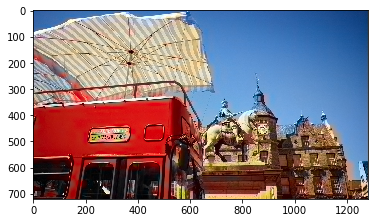

In [5]:
# Check for k-means clustering
img = image_path
clusters = 6
print("clusters: " + str(6))
dc = DominantColors(img, clusters)
colors = dc.dominantColors(algo="kmeans")
db_score = dc.calculate_davies_bouldin_score()
print(db_score)

[[169 104  51]
 [ 86 106 145]
 [170 194 212]
 [ 18  24  59]
 [ 21  23 193]
 [206 149 100]]
<type 'numpy.ndarray'>
[[170 104  51]
 [ 87 106 145]
 [169 194 212]
 [ 19  25  60]
 [ 21  22 193]
 [206 150 100]]
<type 'numpy.ndarray'>
[68, 239]
[205, 135]
[115, 55]
[224, 195]
[193, 40]
[119, 212]


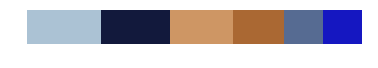

In [158]:
print(colors)
print(dc.getNearestPointTocentroid())
cents = dc.getNearestPointTocentroid()
for point in cents:
#     print(point)
    print(dc.getCoordinates(point))
dc.plotHistogram()
# dc.plotClusters()

In [6]:
from collections import Counter
def getMode(lst):
    return max(set(lst), key=lst.count)
#     data = Counter(lst)
#     data.most_common()   # Returns all unique items and their counts
#     return data.most_common(1) 

In [7]:
def getMedian(lst):
    sort_lst = sorted(lst)
    return sort_lst[len(sort_lst)/2]

In [8]:
colorsInImage = dc.IMAGE
separated = [] # contains colors separated in clusters
for i in range(len(np.unique(dc.LABELS))+1):
    separated.append([])
for color,label in zip(colorsInImage, dc.LABELS):
    separated[label].append(tuple(color))
# print(separated)
mode_colors = [] # to contain the mode colors in every cluster
median_colors = [] # to contain the median colors in every cluster
for i in range(0,len(np.unique(dc.LABELS)),1):
    mode_colors.append(getMode(separated[i]))
    median_colors.append(getMedian(separated[i]))

In [11]:
def showColors(colorPalette):
    
    #creating empty chart
    chart = np.zeros((50, 500, 3), np.uint8)

    #creating color rectangles
    start = 0
    for i in range(len(colorPalette)):
        end = start + 85

        #getting rgb values
        r = int(colorPalette[i][0])
        g = int(colorPalette[i][1])
        b = int(colorPalette[i][2])

        print(r,g,b)

        #using cv2.rectangle to plot colors
        cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
        start = end
    #display chart
    plt.figure()
    plt.axis("off")
    plt.imshow(chart)
    plt.show()

mode_colors
(198, 184, 149)
(119, 87, 76)
(94, 144, 203)
(40, 0, 0)
(183, 21, 16)
(61, 118, 187)


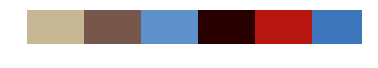

median_colors
(212, 192, 165)
(145, 104, 72)
(98, 153, 213)
(61, 42, 44)
(196, 27, 22)
(54, 111, 180)


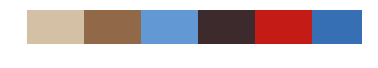

mean_colors
(212, 194, 170)
(145, 106, 86)
(100, 149, 206)
(59, 24, 18)
(193, 23, 21)
(51, 104, 169)


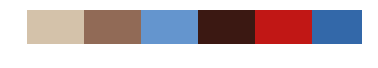

In [12]:
%matplotlib inline
print("mode_colors")
showColors(mode_colors)
print("median_colors")
showColors(median_colors)
print("mean_colors")
showColors(colors)

# dc.COLORS = [[149, 184, 198], [0, 0, 40], [203, 144, 94], [16, 21, 183], [47, 65, 118], [187, 118, 61]]

In [17]:
%matplotlib qt
# Visualize the clusters in the image
orig_img = getResizedImage(image_path)
reshaped_labels = dc.LABELS.reshape(dc.ACTUAL_HEIGHT, dc.ACTUAL_WIDTH)
for i in range(256):
    for j in range(256):
        orig_img[i,j] = colors[reshaped_labels[i,j]]
plt.imshow(orig_img)

In [21]:
mean_colors = dc.getNearestPointTocentroid()
for point in mean_colors:
    print(dc.getCoordinates(point))

<type 'numpy.ndarray'>
[115, 55]
[205, 135]
[119, 212]
[224, 195]
[193, 40]
[68, 239]


In [39]:
# Analyze k-means for different number of clusters
validation_scores = []
for i in range(2,16,1):
    img = image_path
    clusters = i
    print("clusters: " + str(i))
    dc = DominantColors(img, clusters)
    colors = dc.dominantColors()
    # print(colors)
    db_score = dc.calculate_davies_bouldin_score()
    validation_scores.append(db_score)
    print(db_score)

clusters: 2
0.5169749277344062
clusters: 3
0.4660145449310056
clusters: 4
0.5659951944429364
clusters: 5
0.6200106503994323
clusters: 6
0.6392408590354366
clusters: 7
0.7025397708567921
clusters: 8
0.7635603595486299
clusters: 9
0.8297755421645084
clusters: 10
0.8996560807174504
clusters: 11
0.8792540797646797
clusters: 12
0.9218028787375859
clusters: 13
0.889873933078056
clusters: 14
0.9168119408251986
clusters: 15
0.9172189180285168


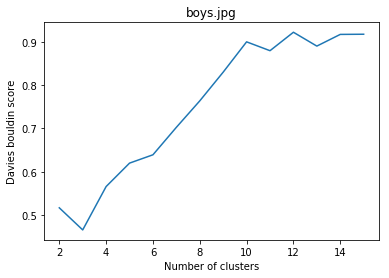

In [40]:
# plot-graph (number of clusters) vs (Davies Bouldin Score)
x = range(2,16,1)
plt.xlabel("Number of clusters")
plt.ylabel("Davies bouldin score")
plt.title("boys.jpg")
plt.plot(x,validation_scores)
# plt.show()
plt.savefig("./graphs/boys.jpg")

In [8]:
# Check for mean-shift clustering algorithm
img = image_path
dc = DominantColors(img, None)
colors = dc.dominantColors(algo="mean-shift")
n_clusters_ = np.unique(dc.LABELS)
db_score = dc.calculate_davies_bouldin_score()

(256, 256, 3)


In [82]:
np.unique?

# Detecting centre of Contour

ZeroDivisionError: float division by zero

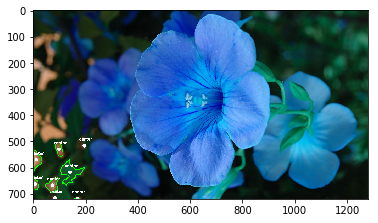

In [13]:
# import the necessary packages
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

image_for_contour = './wallpapers/005.jpg'

# load the image, convert it to grayscale, blur it slightly,
# and threshold it
image = cv2.imread(image_for_contour)
# cv2.imshow("image", image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

# loop over the contours
for c in cnts:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # draw the contour and center of the shape on the image
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(image, "center", (cX - 20, cY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # show the image
#     cv2.imshow("Image", image)
    plt.imshow(image)
#     cv2.waitKey(0)
